In [ ]:
# prompt: 코랩에서 한글을 출력할 수 있게 해주세요

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf



In [13]:
import pandas as pd
import numpy as np
import geopandas as gpd
import os, re
from glob import glob
from tqdm import tqdm
import time
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from graphviz import Source
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

In [ ]:
!wget "https://hycms.hanyang.ac.kr/index.php?module=xn_media_content2013&act=dispXn_media_content2013DownloadContent&content_id=66ef786538650" -O "data.zip"
!unzip  -O cp949 "data.zip" -d "data"

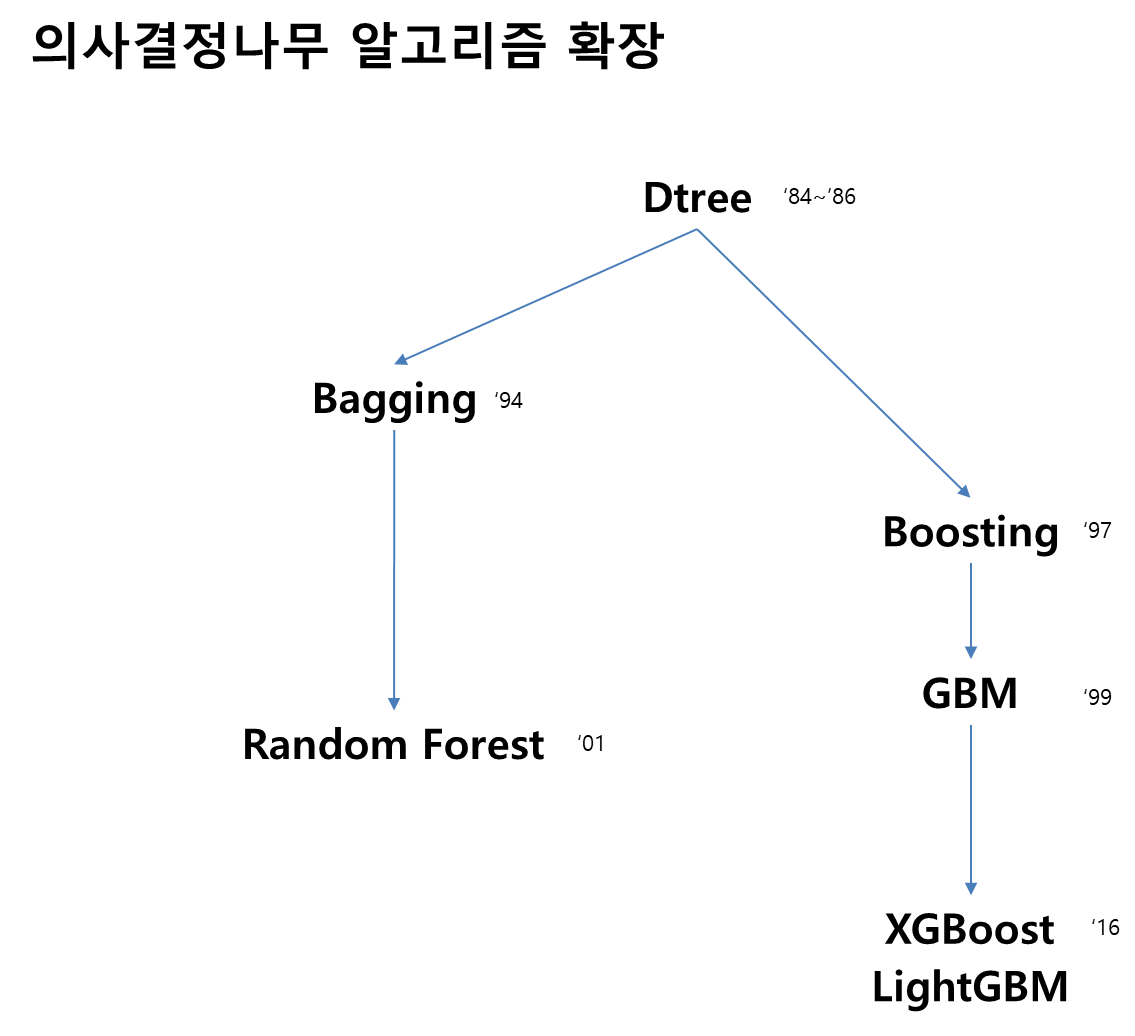

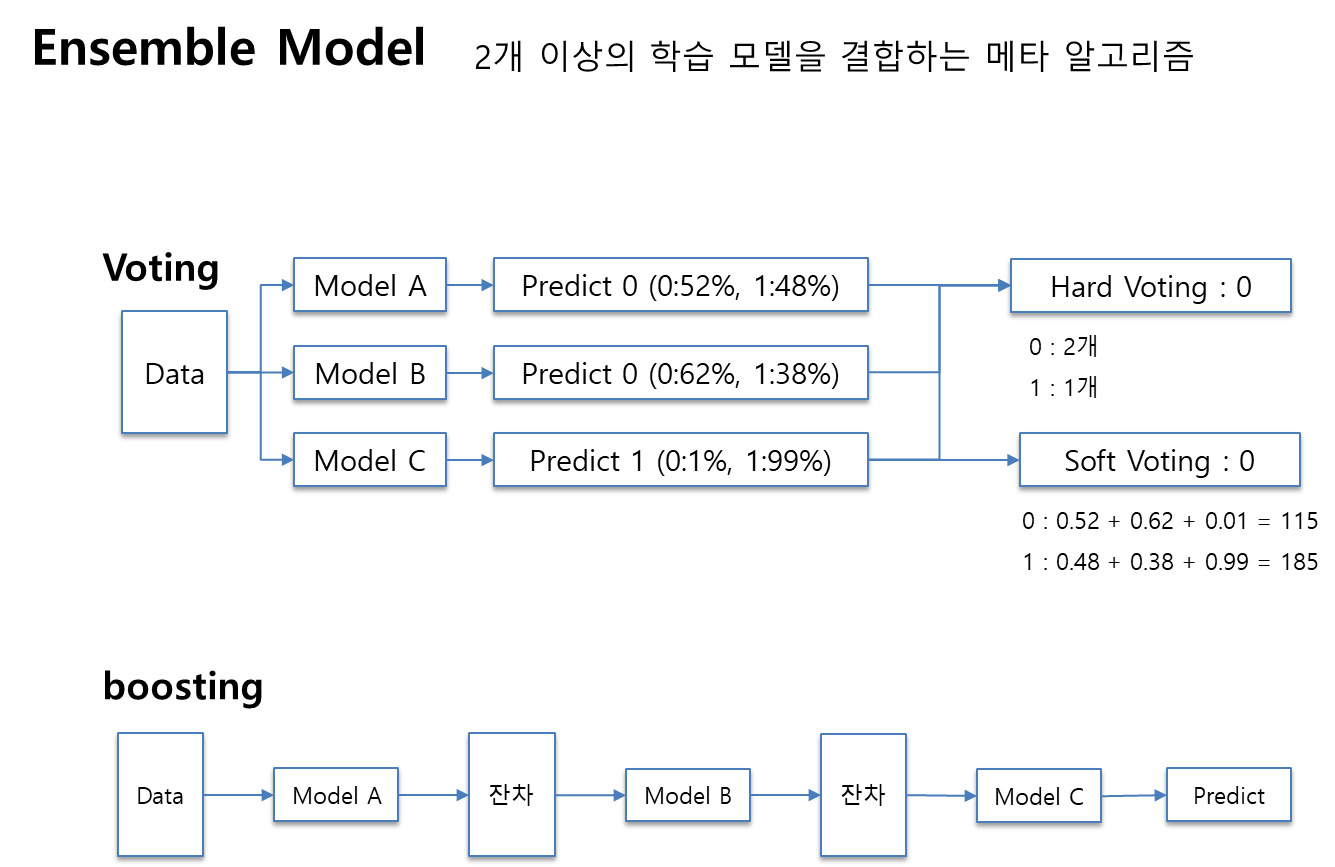

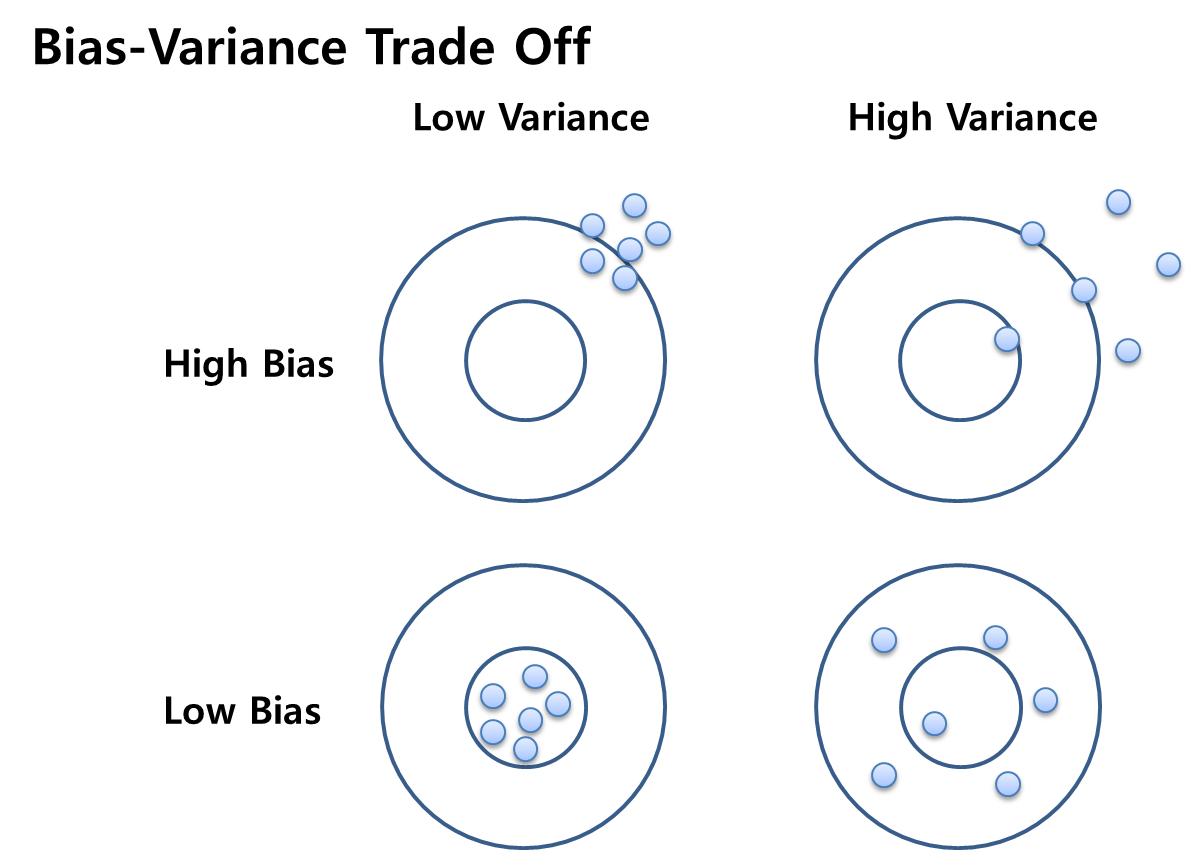

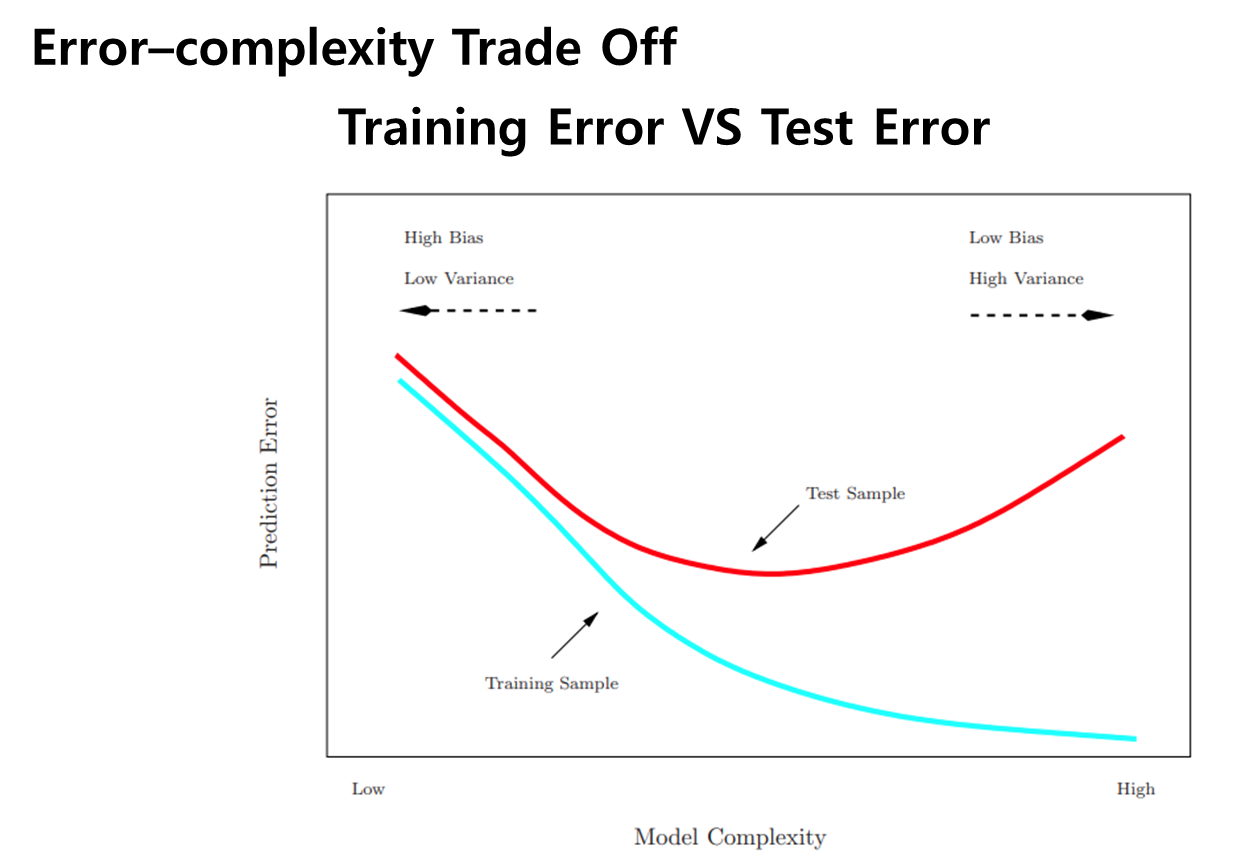

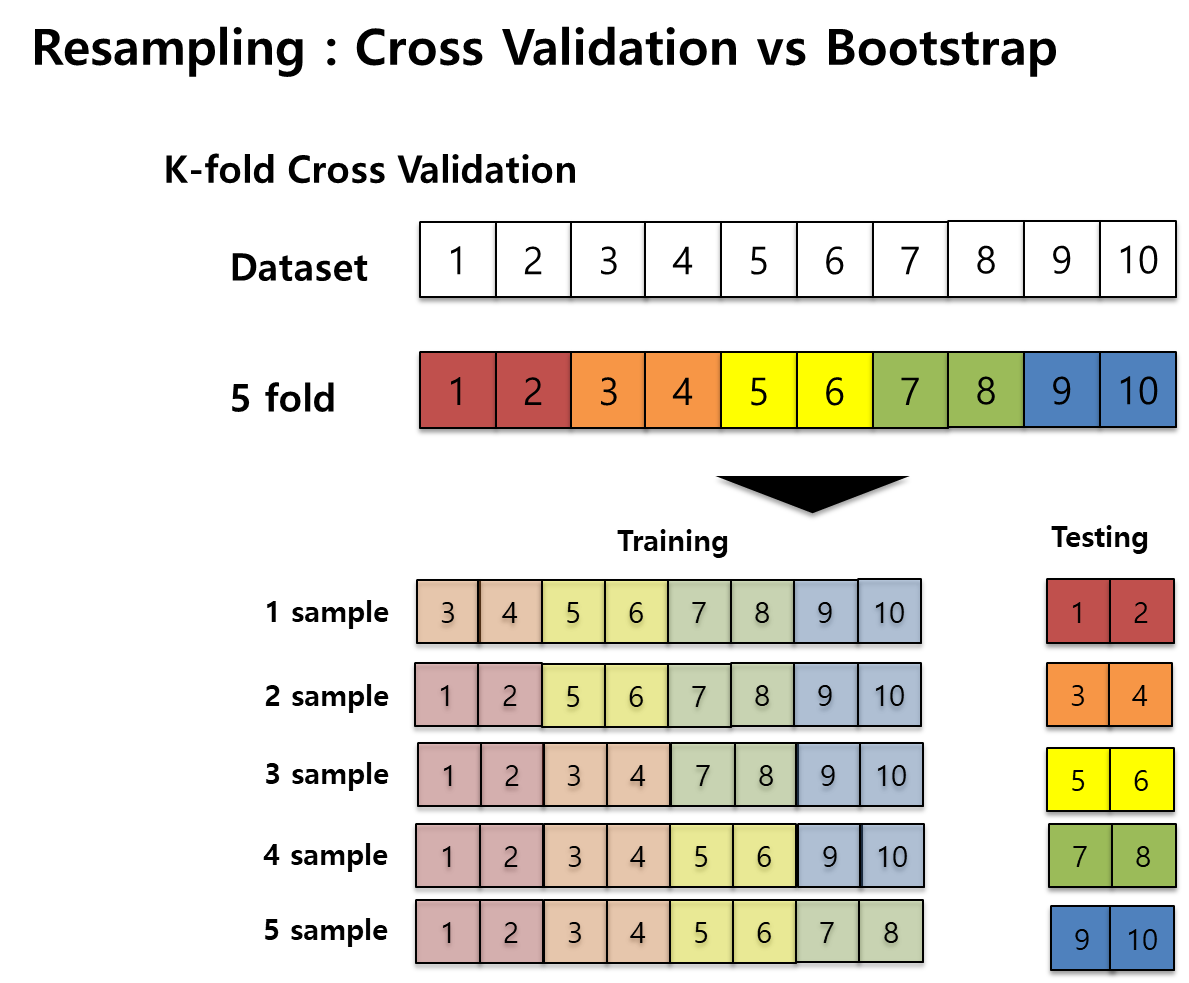

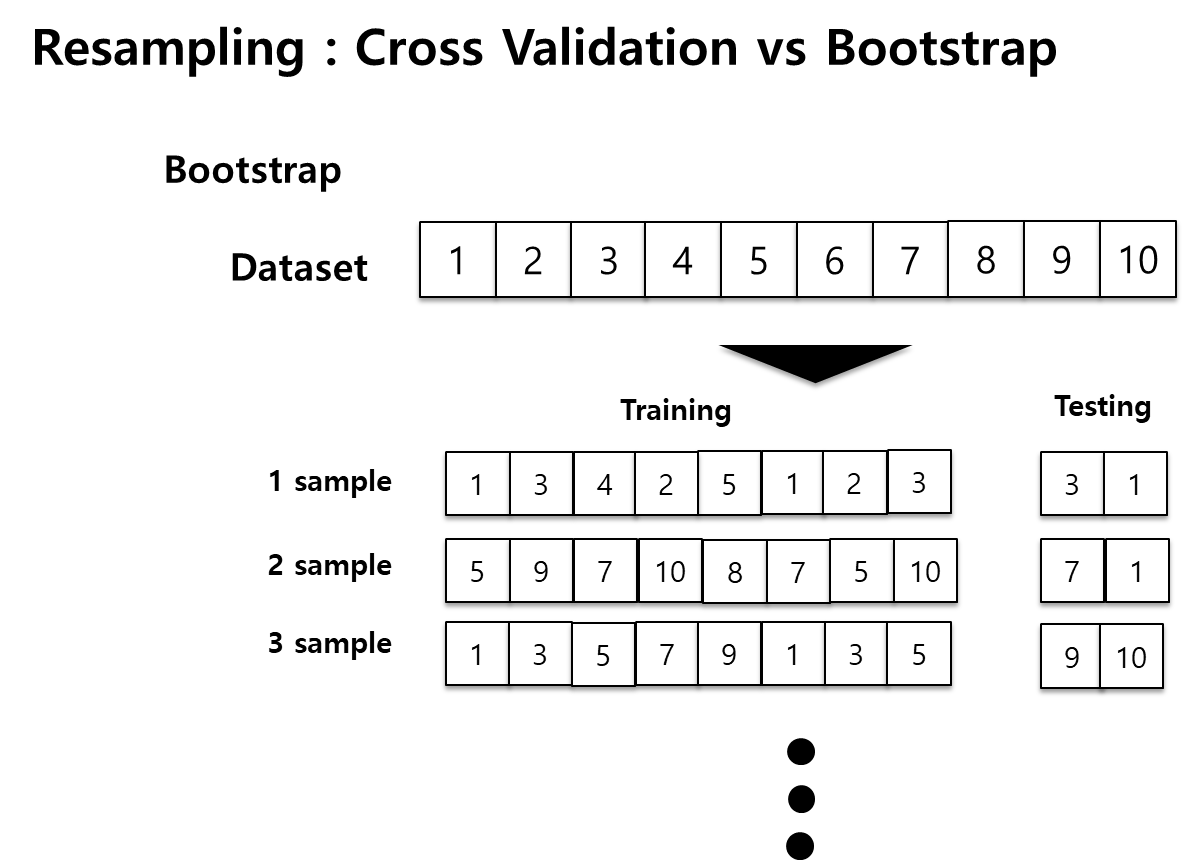

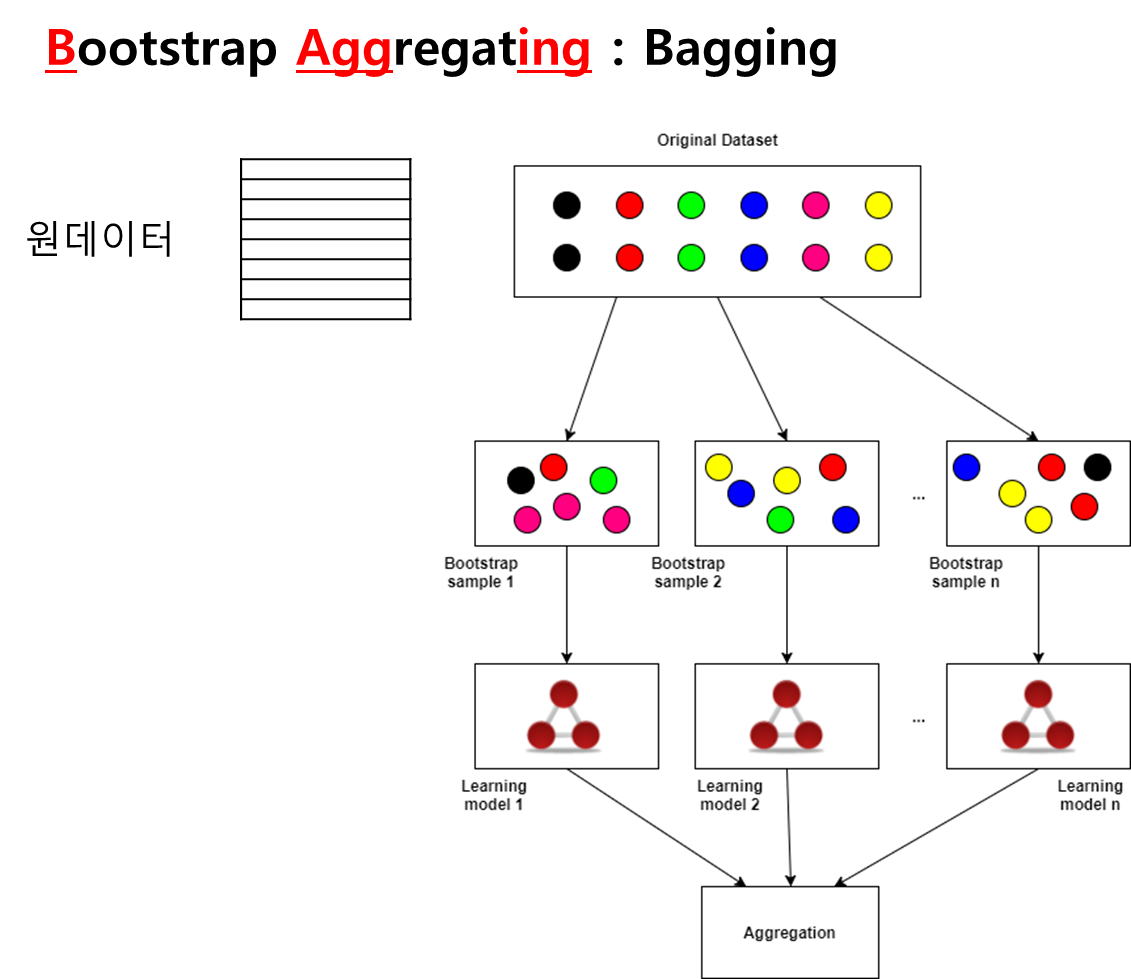

# **스마트서울 도시데이터 센서 (S-Dot) 환경정보**
https://data.seoul.go.kr/dataList/OA-15969/S/1/datasetView.do

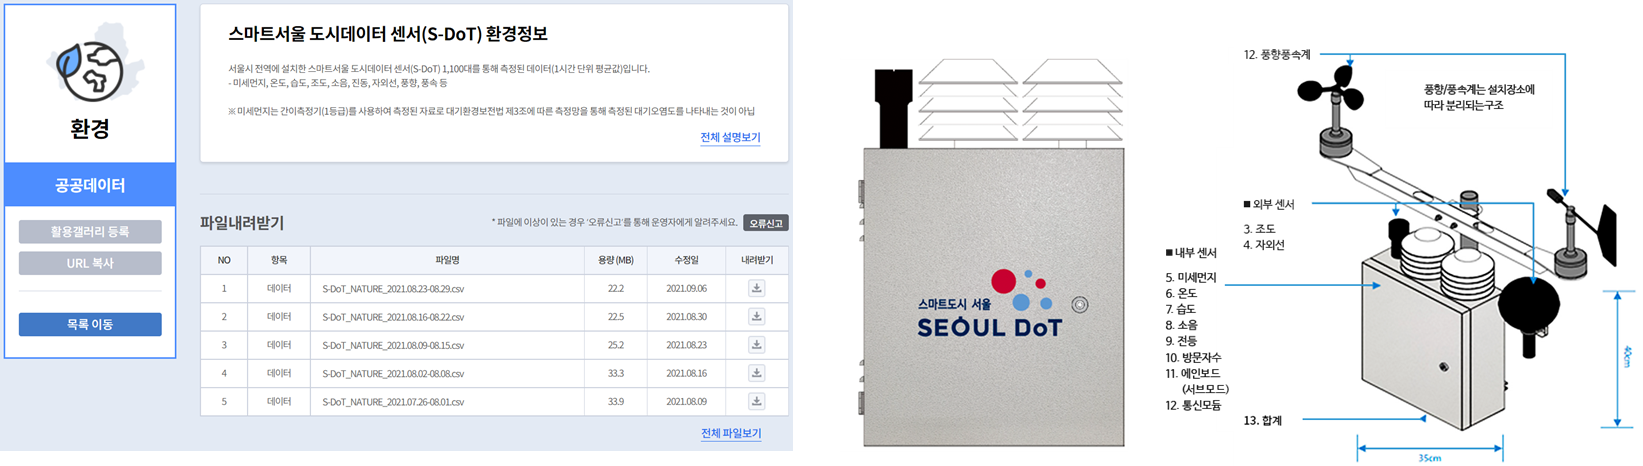

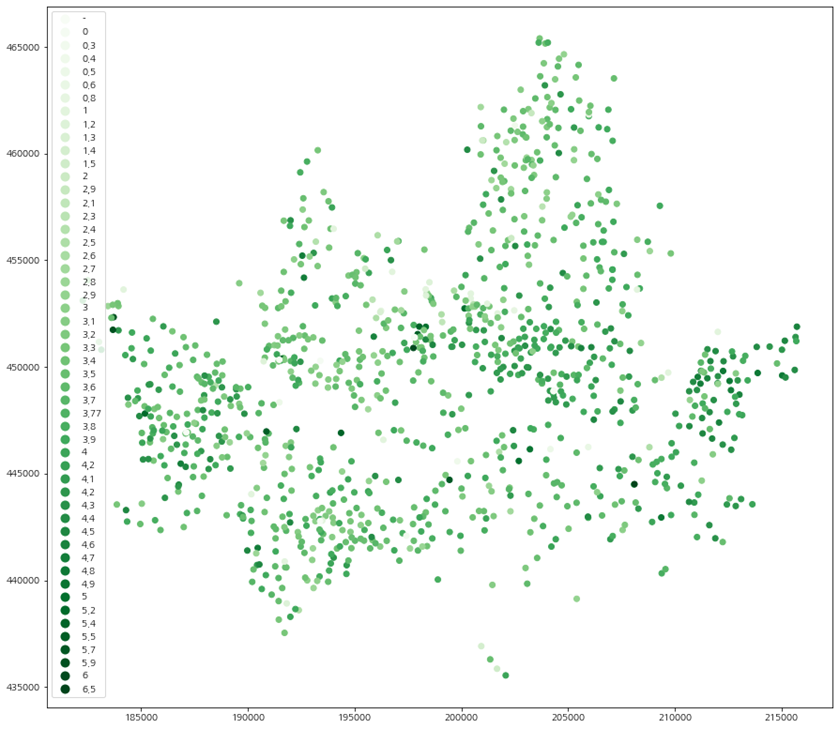

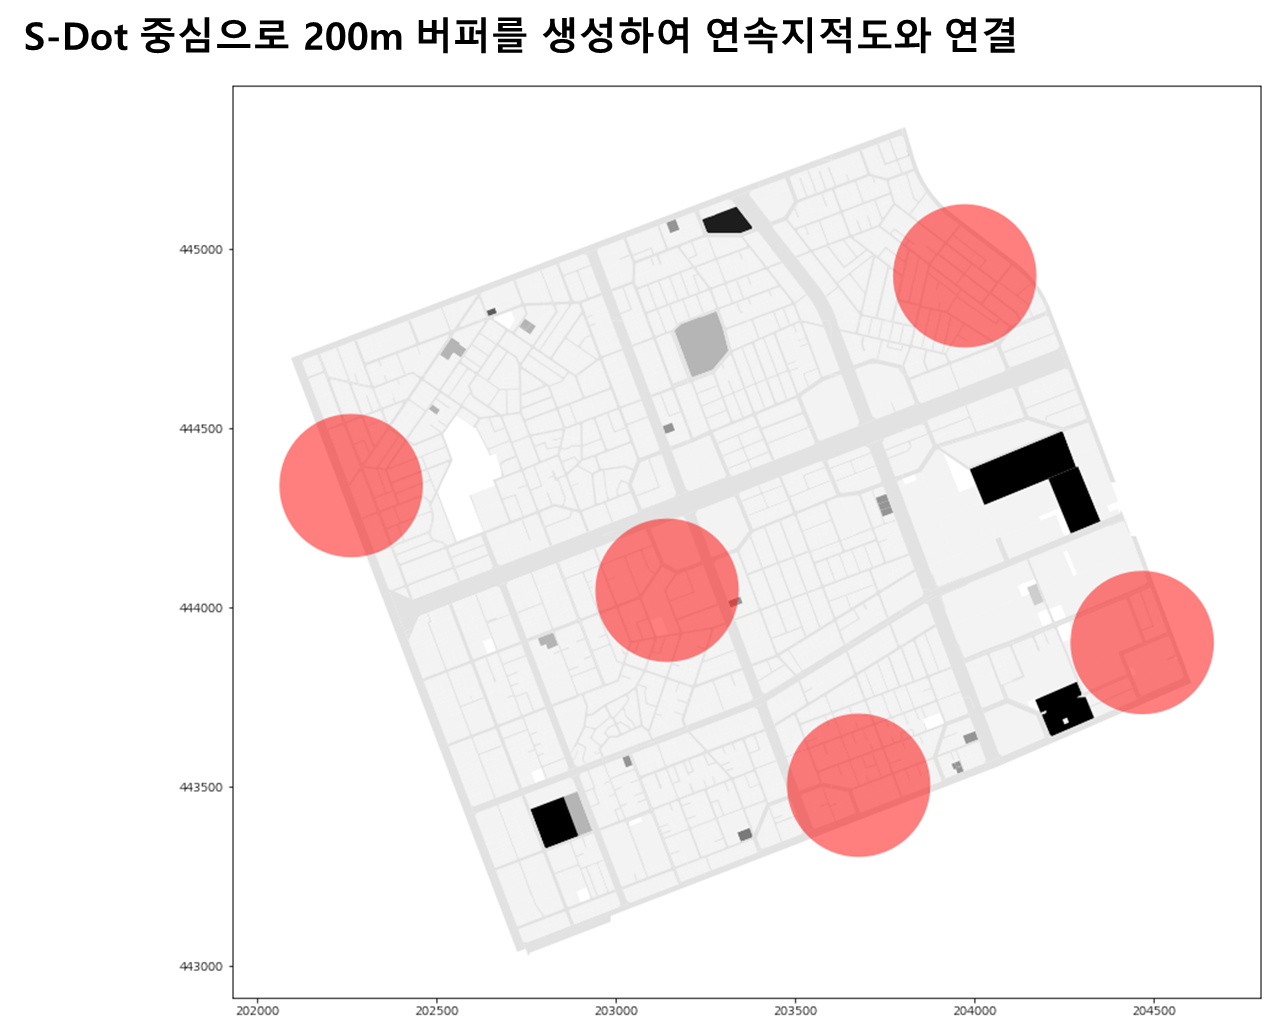

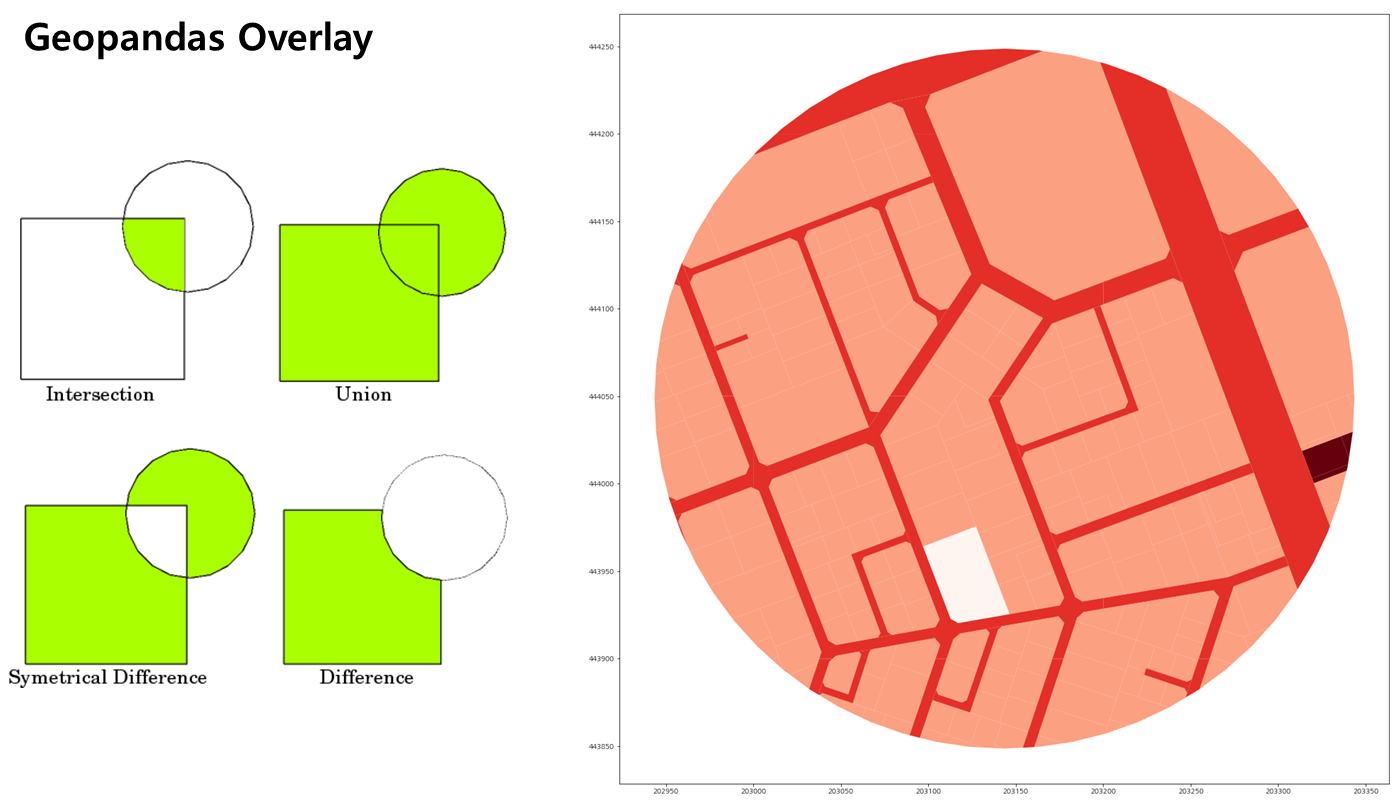

https://github.com/kloud80/urban-data-mining/tree/master/02%20bigdata%20datamining/Sources

In [ ]:

sdot_data_total = pd.read_csv('data/sdot학습데이터.csv', sep='|', encoding='cp949')
"""전체 Sdot 평균기온과의 온도차 평균이 높으면 1, 낮으면 0으로 종속변수 생성"""
sdot_data_total['종속'] = sdot_data_total['온도차이'].apply(lambda x: 0 if x < 0 else 1)

sdot_data_total.columns.values

In [ ]:

""" Tree 모형 분석을 위하 주변 도로 면적비율과, 대지면적 비율 만 불러옴 (도=X, 대=y)"""
tmp = sdot_data_total[['도', '대', '종속']]

""" plot으로 고온그룹과 저온그룹을 2차원에 표시"""
x1 = np.array(tmp[tmp['종속'] == 1][['도', '대']].fillna(0).astype('float').values)
y1 = np.array(tmp[tmp['종속'] == 1]['종속'].values)
y1 = y1.reshape(y1.shape[0], 1)

x2 = np.array(tmp[tmp['종속'] == 0][['도', '대']].fillna(0).astype('float').values)
y2 = np.array(tmp[tmp['종속'] == 0]['종속'].values)
y2 = y2.reshape(y2.shape[0], 1)

plt.figure(figsize=(9, 9))
plt.scatter(x=x1[:, 0], y=x1[:, 1], marker='x', color='red', label='고온')
plt.scatter(x=x2[:, 0], y=x2[:, 1], marker='o', color='blue', label='저온')
plt.legend(fontsize=10)
plt.show()

In [35]:
""" 모든 입력변수를 이용한 분석"""
tmp = sdot_data_total

x = np.array(tmp[tmp.columns.drop(['종속', '시리얼번호', '온도차이', '온도비율차이'])].fillna(0).astype('float').values)
y = np.array(tmp['종속'].values)
y = y.reshape(y.shape[0], 1)


In [ ]:
# prompt: Dtree 로 분석한 tree_clf가 depth가 증가할수록 정확도가 어떻게 증가하는지 보여줘

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)

train_accuracies = []
test_accuracies = []

for depth in range(1, 11):  # depth 1부터 10까지
    tree_clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
    tree_clf.fit(X_train, y_train)

    y_train_pred = tree_clf.predict(X_train)
    y_test_pred = tree_clf.predict(X_test)

    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), train_accuracies, label='Train Accuracy')
plt.plot(range(1, 11), test_accuracies, label='Test Accuracy')
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Tree Depth')
plt.legend()
plt.show()


In [ ]:
"""Bagging Tree"""
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier

"""데이터 나누기"""
#데이터를 training과 testing으로 나눈다
x_train, x_test, y_train, y_test = train_test_split(x,y,                #분할할 행렬
                                                    test_size=0.25,     #검증세트의 분할 비율
                                                    random_state=1,     #순서 섞을 경우 랜덤시드 고정용
                                                    shuffle=True,       #순서 섞을지
                                                    stratify=y)         #분할시 데이터 비율 유지
print(sum(y) / len(y))
print(sum(y_train) / len(y_train))
print(sum(y_test) / len(y_test))


In [ ]:
y_test.shape

In [ ]:
# prompt: BaggingClassifier로 dtree max_depth를 3으로 제한한 상태에서 estimator를 늘리면서 train과 test의 정확도가 어떻게 변하는지 보여줘

train_accuracies = []
test_accuracies = []
estimator_range = range(1, 101, 5)  # 1부터 100까지 5씩 증가

for n_estimators in estimator_range:
    model_baggingtree = BaggingClassifier(
        DecisionTreeClassifier(max_depth=3), n_estimators=n_estimators
    )
    model_baggingtree.fit(x_train, y_train.ravel())

    train_accuracy = model_baggingtree.score(x_train, y_train)
    test_accuracy = model_baggingtree.score(x_test, y_test)

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

plt.figure(figsize=(10, 6))
plt.plot(estimator_range, train_accuracies, label="Train Accuracy")
plt.plot(estimator_range, test_accuracies, label="Test Accuracy")
plt.xlabel("Number of Estimators")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of Estimators (Bagging with max_depth=3)")
plt.legend()
plt.show()


In [ ]:
feature_imp = np.mean([
    tree.feature_importances_ for tree in model_baggingtree.estimators_
], axis=0)
n_feature = len(tmp.columns.drop(['종속', '시리얼번호', '온도차이', '온도비율차이']))
idx = np.arange(n_feature)
sorted_idx = feature_imp.argsort()

plt.figure(figsize=(5, 25))
plt.barh(idx, feature_imp[sorted_idx], align='center')
plt.yticks(idx, tmp.columns.drop(['종속', '시리얼번호', '온도차이', '온도비율차이'])[sorted_idx])
plt.xlabel('feature importance', size=15)
plt.ylabel('feature', size=15)
plt.show()

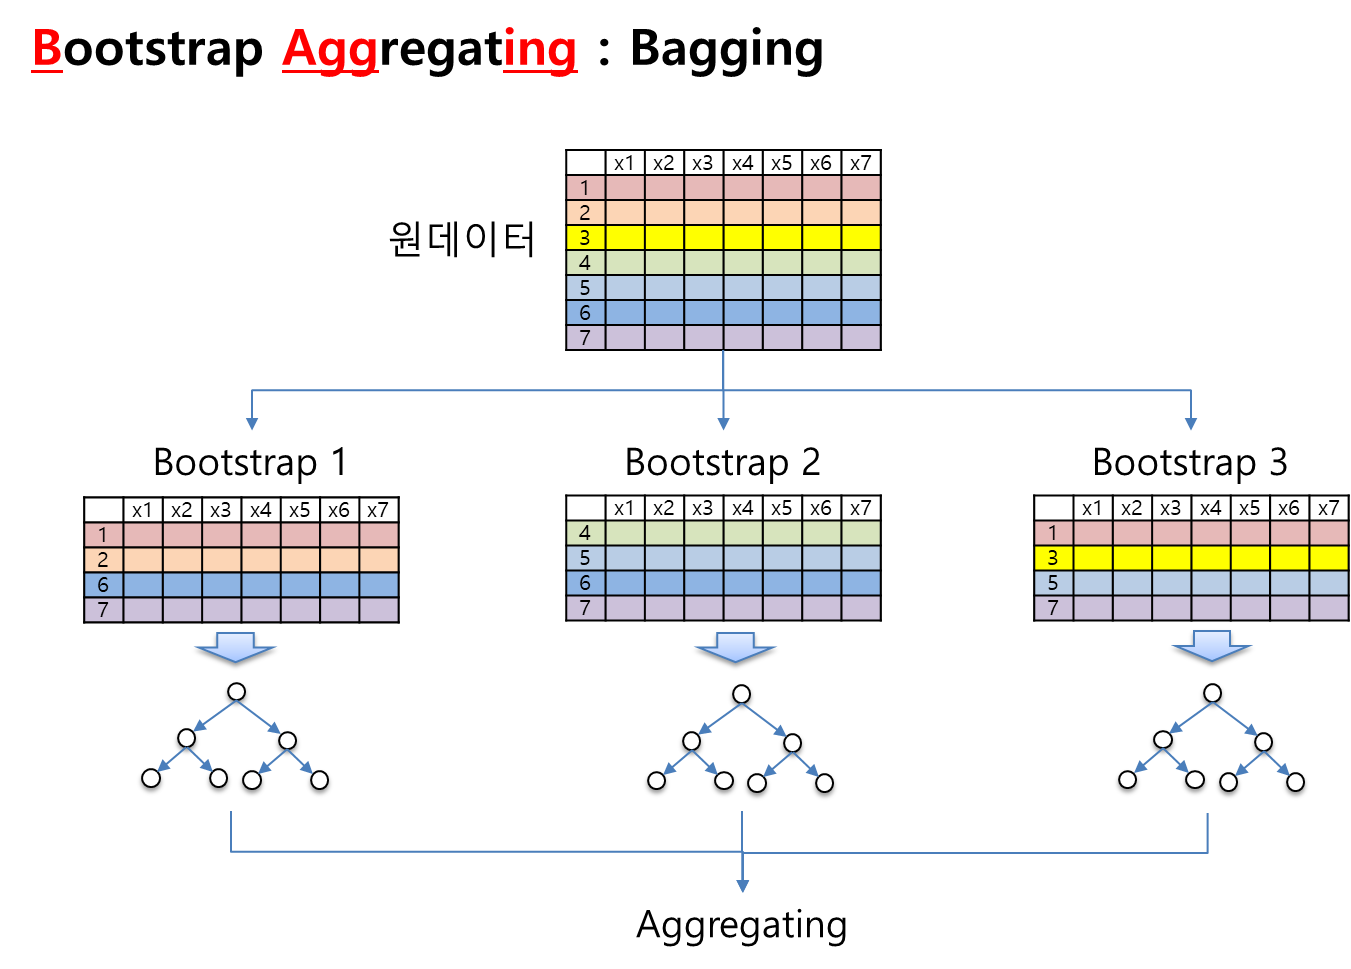

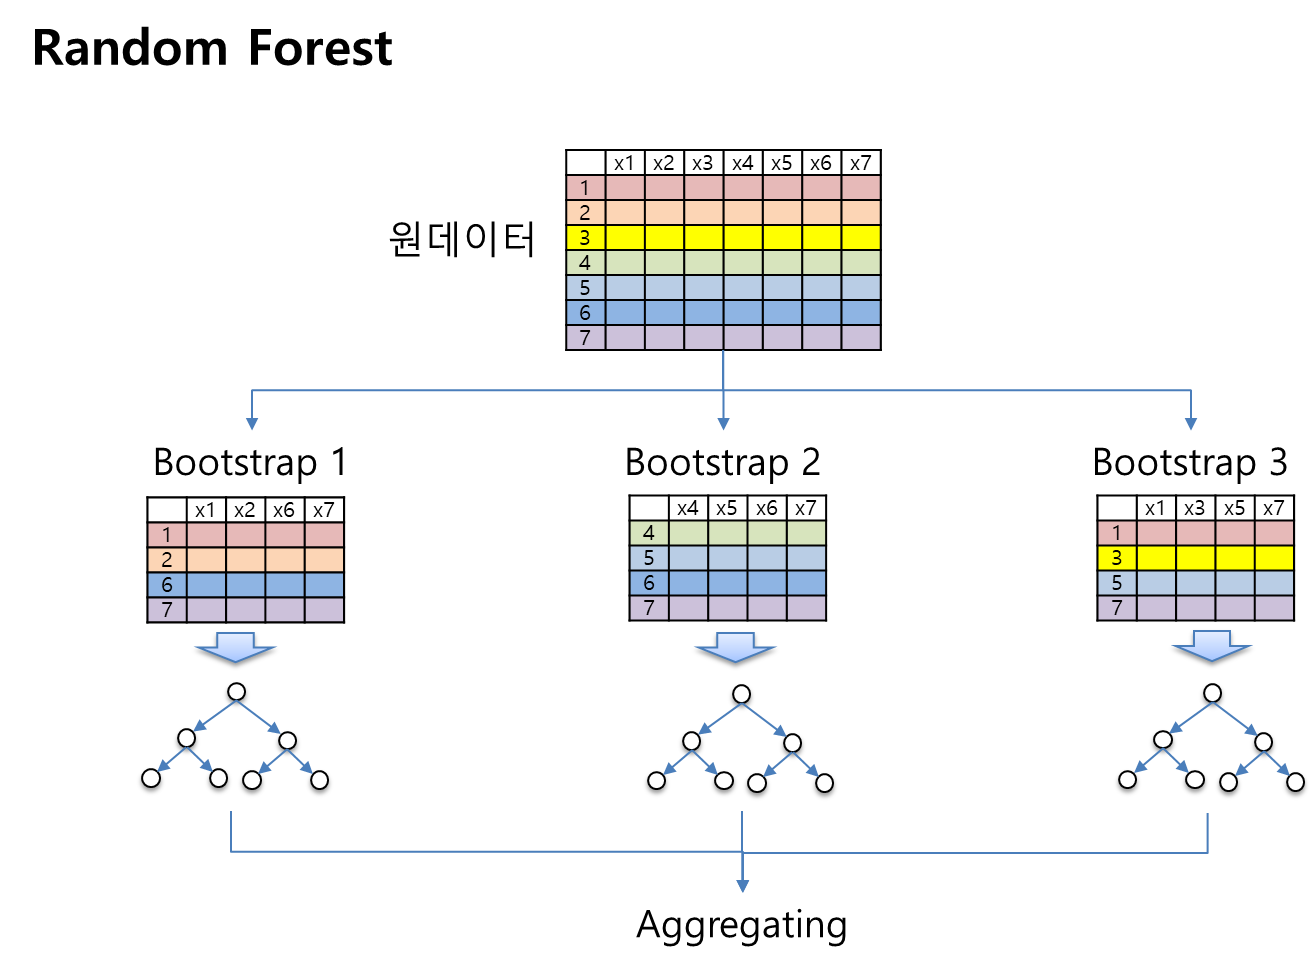

In [ ]:
# prompt: RandomForestClassifier로 dtree max_depth를 3으로 제한한 상태에서 estimator를 늘리면서 train과 test의 정확도가 어떻게 변하는지 보여줘

from sklearn.ensemble import RandomForestClassifier

train_accuracies = []
test_accuracies = []
estimator_range = range(1, 101,5)  # 1부터 100까지 5씩 증가

for n_estimators in tqdm(estimator_range):
    rf_classifier = RandomForestClassifier(n_estimators=n_estimators, max_depth=3, random_state=42)
    rf_classifier.fit(x_train, y_train.ravel())

    train_accuracy = rf_classifier.score(x_train, y_train)
    test_accuracy = rf_classifier.score(x_test, y_test)

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

# 결과 시각화
plt.figure(figsize=(10, 6))
plt.plot(estimator_range, train_accuracies, label='Train Accuracy')
plt.plot(estimator_range, test_accuracies, label='Test Accuracy')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy vs. Number of Estimators (RandomForest, max_depth=3)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:

m = model_baggingtree[2]
dt_dot_data  = export_graphviz(m,
                               feature_names=tmp.columns.drop(['종속', '시리얼번호', '온도차이', '온도비율차이']),
                               class_names=['저온', '고온'],         # 종속변수
                               rounded = True,
                               filled = True)

graph = Source(dt_dot_data)
display(graph)

In [ ]:

m = rf_classifier[2]
dt_dot_data  = export_graphviz(m,
                               feature_names=tmp.columns.drop(['종속', '시리얼번호', '온도차이', '온도비율차이']),
                               class_names=['저온', '고온'],         # 종속변수
                               rounded = True,
                               filled = True)

graph = Source(dt_dot_data)
display(graph)

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=n_estimators, max_depth=3)
rf_classifier.fit(x_train, y_train.ravel())

"""변수중요도"""
feature_imp = np.mean([
    tree.feature_importances_ for tree in rf_classifier.estimators_
], axis=0)
n_feature = len(tmp.columns.drop(['종속', '시리얼번호', '온도차이', '온도비율차이']))
idx = np.arange(n_feature)
sorted_idx = feature_imp.argsort()

plt.figure(figsize=(5, 25))
plt.barh(idx, feature_imp[sorted_idx], align='center')
plt.yticks(idx, tmp.columns.drop(['종속', '시리얼번호', '온도차이', '온도비율차이'])[sorted_idx])
plt.xlabel('feature importance', size=15)
plt.ylabel('feature', size=15)
plt.show()

In [ ]:

from sklearn.inspection import permutation_importance

result = permutation_importance(rf_classifier, x_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()


plt.figure(figsize=(5, 25))
plt.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=tmp.columns.drop(['종속', '시리얼번호', '온도차이', '온도비율차이'])[sorted_idx])

plt.show()
